# Predicting Diatom concentration with functional regression

## Importing

In [17]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xskillscore as xs

from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import root_mean_squared_error as rmse

from skfda.ml.regression import KNeighborsRegressor
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import FourierBasis

import os
import lzma
import dill

import random

import salishsea_tools.viz_tools as sa_vi


## Datasets Preparation

In [18]:
# Creation of the training - testing datasets
def datasets_preparation(dataset, dataset2, ref, name):
    
    inputs = np.stack([np.reshape(np.ravel(dataset['Temperature_(0m-15m)']), (len(ref.time_counter), len(np.unique(dataset.time_counter.dt.year))*len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset['Temperature_(15m-100m)']),(len(ref.time_counter), len(np.unique(dataset.time_counter.dt.year))*len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset['Salinity_(0m-15m)']), (len(ref.time_counter), len(np.unique(dataset.time_counter.dt.year))*len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset['Salinity_(15m-100m)']), (len(ref.time_counter), len(np.unique(dataset.time_counter.dt.year))*len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset2['Summation_of_solar_radiation']), (len(ref.time_counter), len(np.unique(dataset.time_counter.dt.year))*len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset2['Mean_wind_speed']), (len(ref.time_counter), len(np.unique(dataset.time_counter.dt.year))*len(dataset.y) * len(dataset.x))),
        np.reshape(np.ravel(dataset2['Mean_air_temperature']), (len(ref.time_counter), len(np.unique(dataset.time_counter.dt.year))*len(dataset.y) * len(dataset.x))),
        ])

    x =  np.tile(dataset.x, len(np.unique(dataset.time_counter.dt.year))*len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),len(np.unique(dataset.time_counter.dt.year)))

    indx = np.where((~np.isnan(inputs[1]).any(axis=0)) & (x>10) & ((x>100) | (y<880))) # Because inputs[1] goes down to 100m
    inputs = inputs[:,:,indx[0]]

    # Scaling the inputs
    for j in range (0, len(inputs)):

        temp = scale(np.ravel(inputs[j]))
        inputs[j] = temp.reshape(inputs[j].shape)

    # Final transformations of inputs
    inputs = np.transpose(inputs,axes=(2,1,0))
    inputs = FDataGrid(data_matrix=inputs, grid_points=np.arange(0,len(ref.time_counter)))

    targets = np.reshape(np.ravel(dataset[name]), (len(ref.time_counter), len(np.unique(dataset.time_counter.dt.year))*len(dataset.y) * len(dataset.x)))
    targets = targets[:,indx[0]]

    return(inputs, targets, indx)


## Datasets Preparation 2

In [19]:
# Creation of the data arrays
def datasets_preparation2(variable, name, units, dataset):

    # Obtaining the daily indexes
    temp = np.reshape(np.ravel(dataset['Temperature_(15m-100m)']), (len(dataset.time_counter), len(dataset.y) * len(dataset.x)))
    x =  np.tile(dataset.x, len(dataset.y))
    y =  np.tile(np.repeat(dataset.y, len(dataset.x)),1)

    indx = np.where((~np.isnan(temp).any(axis=0)) & (x>10) & ((x>100) | (y<880)))

    variable_all = np.full((len(dataset.time_counter), len(dataset.y) * len(dataset.x)),np.nan)
    variable_all[:,indx[0]] = variable
    variable_all = np.reshape(variable_all,(len(dataset.time_counter),len(dataset.y),len(dataset.x)))

    # Preparation of the dataarray 
    array = xr.DataArray(variable_all,
        coords = {'time_counter': dataset.time_counter,'y': dataset.y, 'x': dataset.x},
        dims = ['time_counter','y','x'],
        attrs=dict(description= name,
        units=units))
        
    return (array)


## File Creation

In [20]:
def file_creation(path, variable, name):

    temp = variable.to_dataset(name=name)
    temp.to_netcdf(path = path + 't_p.nc', mode='w', encoding={name:{"zlib": True, "complevel": 9}})
    

## Regressor

In [21]:
def regressor (inputs, targets):

    # Scaling the targets
    scaler = StandardScaler()
    temp = np.ravel(targets)
    temp = np.expand_dims(temp,axis=1)
    temp = scaler.fit_transform(temp)
    targets = temp.reshape(targets.shape)

    # Final transformations of targets
    targets = targets.transpose()
    targets = FDataGrid(data_matrix=targets, grid_points=np.arange(0,len(targets[0])))

    # Smoothing
    # targets = targets.to_basis(FourierBasis(n_basis=5))

    regr = KNeighborsRegressor(n_neighbors=10,n_jobs=4)
    regr.fit(inputs, targets)

    return(regr,scaler)


## Scatter Plot

In [22]:
def scatter_plot(targets, predictions, name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, predictions, deg=1)

    fig, ax = plt.subplots(2, figsize=(5,10), layout='constrained')

    ax[0].scatter(targets,predictions, alpha = 0.2, s = 10)

    lims = [np.min([ax[0].get_xlim(), ax[0].get_ylim()]),
        np.max([ax[0].get_xlim(), ax[0].get_ylim()])]

    # plot fitted y = m*x + b
    ax[0].axline(xy1=(0, b), slope=m, color='r')

    ax[0].set_xlabel('targets')
    ax[0].set_ylabel('predictions')
    ax[0].set_xlim(lims)
    ax[0].set_ylim(lims)
    ax[0].set_aspect('equal')

    ax[0].plot(lims, lims,linestyle = '--',color = 'k')

    h = ax[1].hist2d(targets,predictions, bins=100, cmap='jet', 
        range=[lims,lims], cmin=0.1, norm='log')
    
    ax[1].plot(lims, lims,linestyle = '--',color = 'k')

    # plot fitted y = m*x + b
    ax[1].axline(xy1=(0, b), slope=m, color='r')

    ax[1].set_xlabel('targets')
    ax[1].set_ylabel('predictions')
    ax[1].set_aspect('equal')

    fig.colorbar(h[3],ax=ax[1], location='bottom')

    fig.suptitle(name)

    plt.show()

    return(m)


## Plotting (Criteria)

In [23]:
def plotting_criteria(dates, variable, year_variable, title):
    
    indx = pd.DatetimeIndex(dates)
    fig, ax = plt.subplots()

    scatter= ax.scatter(dates,variable, marker='.', c=indx.month)
    plt.xticks(rotation=70)
    ax.legend(handles=scatter.legend_elements()[0], labels=['February','March','April'])
    ax.plot(dates[(indx.month == 3) & (indx.day == 15)], year_variable,color='red',marker='*')
    fig.suptitle(title + ' (15 Feb - 30 Apr)')
    
    fig.show()


## Plotting (Mean Values)

In [24]:
def plotting_mean_values(dates, mean_targets, mean_predictions, units):

    fig, _ = plt.subplots()
    
    plt.plot(dates,(mean_targets), marker = '.', linestyle = '', label = 'targets')
    plt.plot(dates,(mean_predictions), marker = '.', linestyle = '', label = 'predictions')
    plt.xlabel('Years')
    plt.xticks(rotation=70)
    plt.suptitle('Concentrations ' + units + ' (15 Feb - 30 Apr)')
    plt.legend()
    fig.show()
    

## Plotting (Maps)

In [25]:
def plotting_maps(targets, predictions, name, units):

    fig, ax = plt.subplots(2,2, figsize = (10,15), layout='tight')

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    targets.plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': name + ' ' + units})
    predictions.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': name + ' ' + units})
    (targets-predictions).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': name + ' ' + units})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.95, 
        top=0.95, 
        wspace=0.35, 
        hspace=0.35)

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])

    ax[0,0].title.set_text('Targets')
    ax[0,1].title.set_text('Predictions')
    ax[1,0].title.set_text('Targets-Predictions')
    ax[1,1].axis('off')

    fig.suptitle(name + ' '+ str(targets.time_counter.dt.date.values))

    plt.show()
    

## Evaluation

In [26]:
def evaluation (regr, ds, ds2, ref, name, units, scaler):

    years = np.unique(ds.time_counter.dt.year)

    # For every year
    r_years = np.array([])
    rms_years = np.array([])
    slope_years = np.array([])

    # The data arrays 
    targets_all = []
    predictions_all = []

    for year in (years):

        dataset = ds.sel(time_counter=str(year))
        dataset2 = ds2.sel(time_counter=str(year))
    
        inputs, targets, indx = datasets_preparation(dataset, dataset2, ref, name)

        temp = np.ravel(targets)
        temp = np.expand_dims(temp,axis=1)
        temp = scaler.fit_transform(temp)
        targets2 = temp.reshape(targets.shape)

        # Final transformations of targets
        targets2 = targets2.transpose()
        targets2 = FDataGrid(data_matrix=targets2, grid_points=np.arange(0,len(targets2[0])))

        # Post-processing of predictions
        predictions = regr.predict(inputs)
        predictions = np.array(predictions.to_grid(np.arange(0,len(dataset.time_counter))).data_matrix)
        predictions = np.squeeze(predictions,2)

        # Inverse scaling
        temp = np.ravel(predictions)
        temp = np.expand_dims(temp,axis=1)
        temp = scaler.inverse_transform(temp)
        predictions = temp.reshape(predictions.shape)
        predictions = predictions.transpose()

        # Calculating the annual time-series
        m_year = scatter_plot(np.ravel(targets), np.ravel(predictions), name + ' for '+ str(year)) 
        r_year = np.corrcoef(np.ravel(targets), np.ravel(predictions))[0][1]
        rms_year = rmse(np.ravel(targets), np.ravel(predictions))

        r_years = np.append(r_years,r_year)
        rms_years = np.append(rms_years,rms_year)
        slope_years = np.append(slope_years,m_year)

        # Daily arrays
        # targets = np.reshape(targets,(len(dataset.time_counter), int(len(indx[0]) / len(dataset.time_counter))))
        # predictions = np.reshape(predictions,(len(dataset.time_counter), int(len(indx[0]) / len(dataset.time_counter))))
        targets_all.append (datasets_preparation2(targets, name + ' _targets', units, dataset))
        predictions_all.append(datasets_preparation2(predictions, name + ' _predictions', units, dataset))  

    # Daily arrays
    targets_all = xr.concat(targets_all, dim='time_counter')
    predictions_all = xr.concat(predictions_all, dim='time_counter') 

    
    return(r_years, rms_years, slope_years, targets_all, predictions_all)


## Training

In [27]:
name = 'Diatom'
units = '[mmol m-2]'

ds = xr.open_dataset('/data/ibougoudis/MOAD/files/integrated_original.nc')
ds2 = xr.open_dataset('/data/ibougoudis/MOAD/files/external_inputs.nc')

ds = ds.isel(y=(np.arange(ds.y[0], ds.y[-1], 5)), 
    x=(np.arange(ds.x[0], ds.x[-1], 5)))

ds2 = ds2.isel(y=(np.arange(ds2.y[0], ds2.y[-1], 5)), 
    x=(np.arange(ds2.x[0], ds2.x[-1], 5)))

dataset = ds.sel(time_counter = slice('2007', '2020'))
dataset2 = ds2.sel(time_counter = slice('2007', '2020'))
ref = ds.sel(time_counter='2007')

indx = (dataset.time_counter.dt.month==2) & (dataset.time_counter.dt.day==29)
test= np.where(dataset.time_counter[~indx])
dataset = dataset.sel(time_counter=dataset.time_counter[~test[0]])
dataset2 = dataset2.sel(time_counter=dataset2.time_counter[~test[0]])

inputs, targets, _ = datasets_preparation(dataset, dataset2, ref, name)

regr,scaler = regressor(inputs, targets)


## Other Years

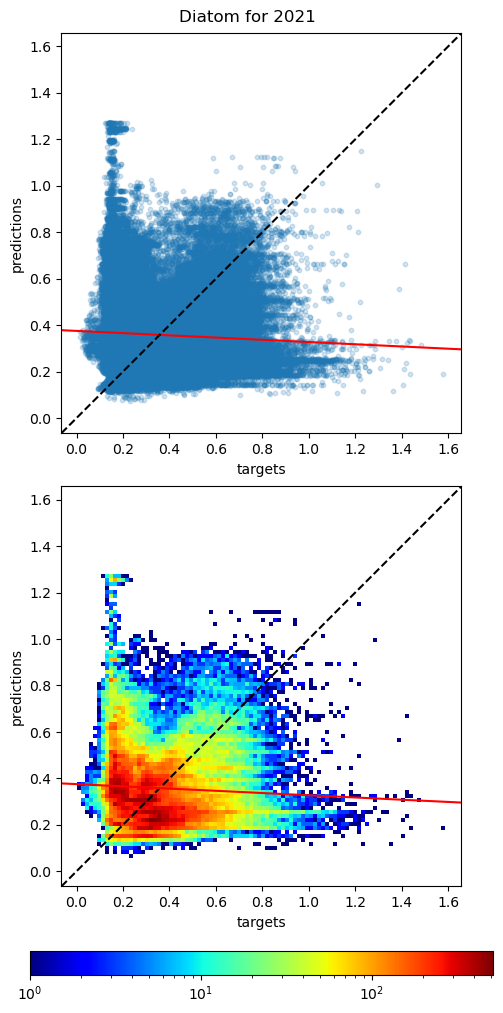

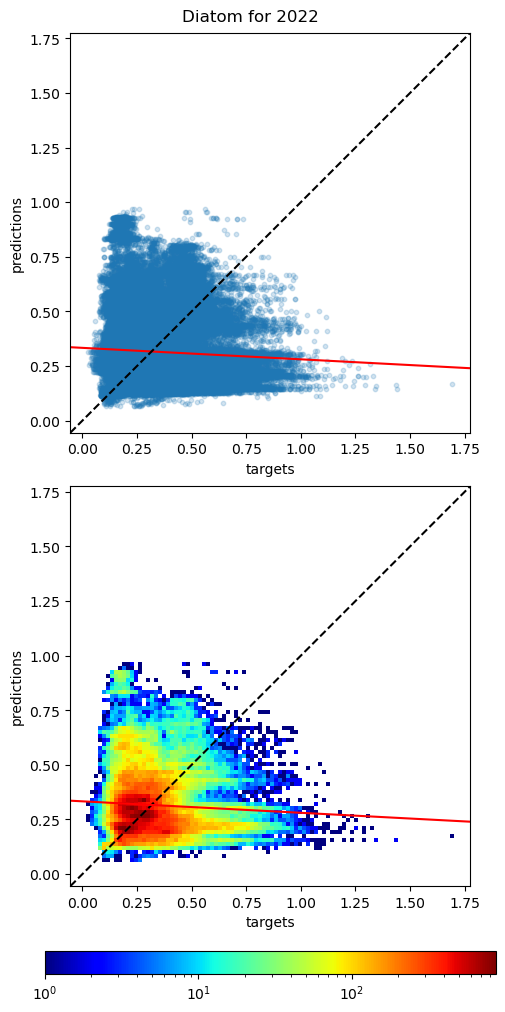

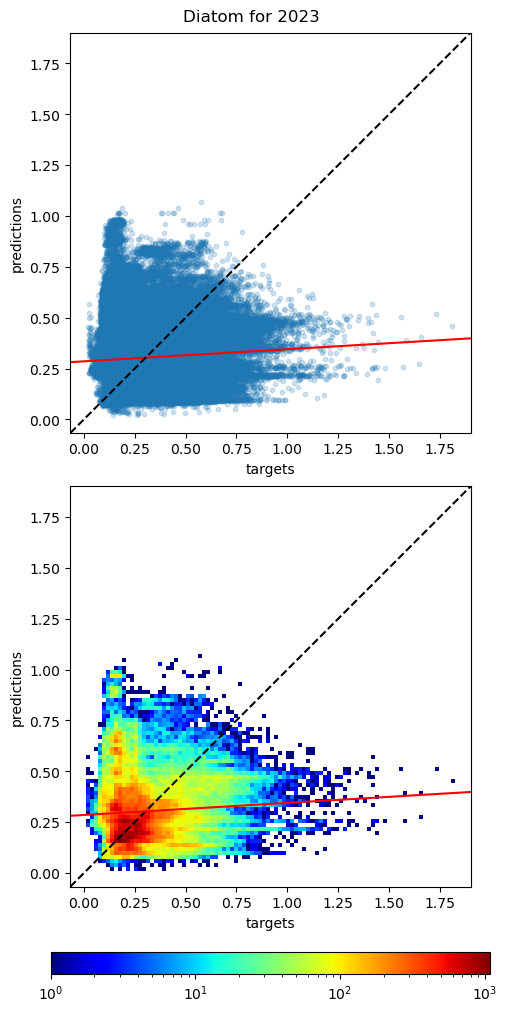

In [ ]:
ds = ds.sel(time_counter = slice('2021', '2023'))
ds2 = ds2.sel(time_counter = slice('2021', '2023'))

dates = pd.DatetimeIndex(ds['time_counter'].values)

r_years, rms_years, slope_years, targets_all, predictions_all = evaluation(regr,ds,ds2,ref,name,units,scaler)

r_days = xr.corr(targets_all,predictions_all, dim=['x','y'])
rms_days = xs.rmse(targets_all,predictions_all, dim=['x','y'], skipna=True)
slope_days = xs.linslope(targets_all,predictions_all, dim=['x','y'], skipna=True)

mean_targets = targets_all.mean(dim=['x','y'], skipna=True)
mean_predictions = predictions_all.mean(dim=['x','y'], skipna=True)


## Plotting (Results)

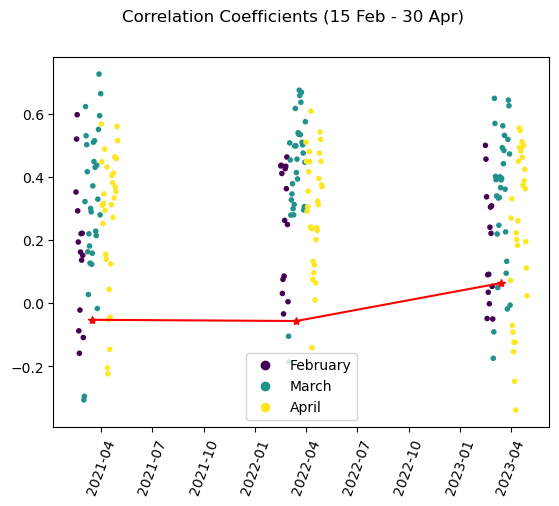

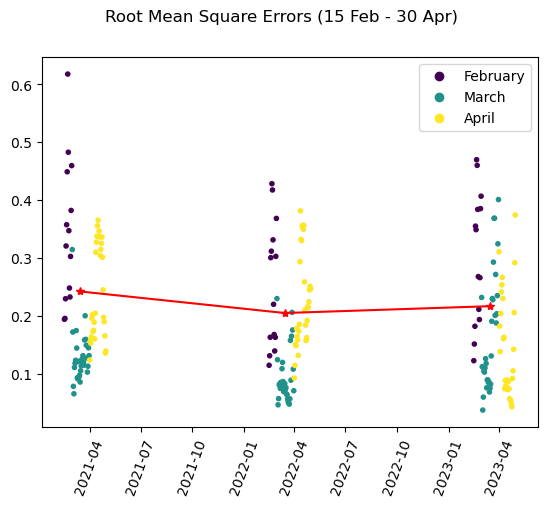

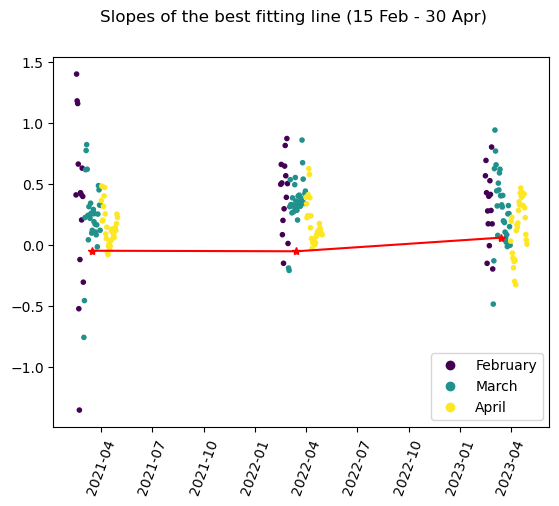

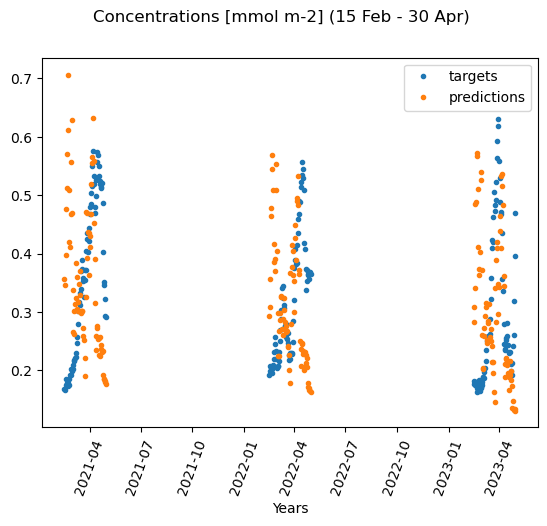

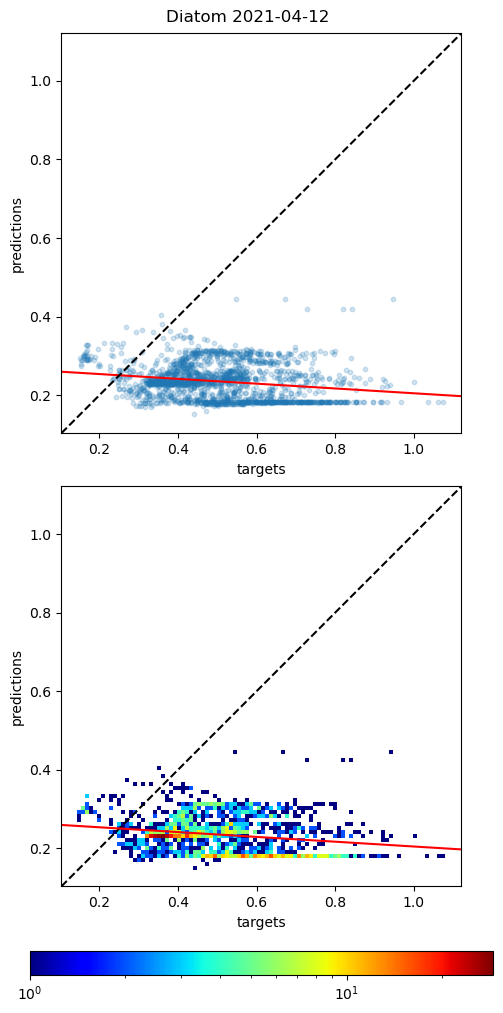

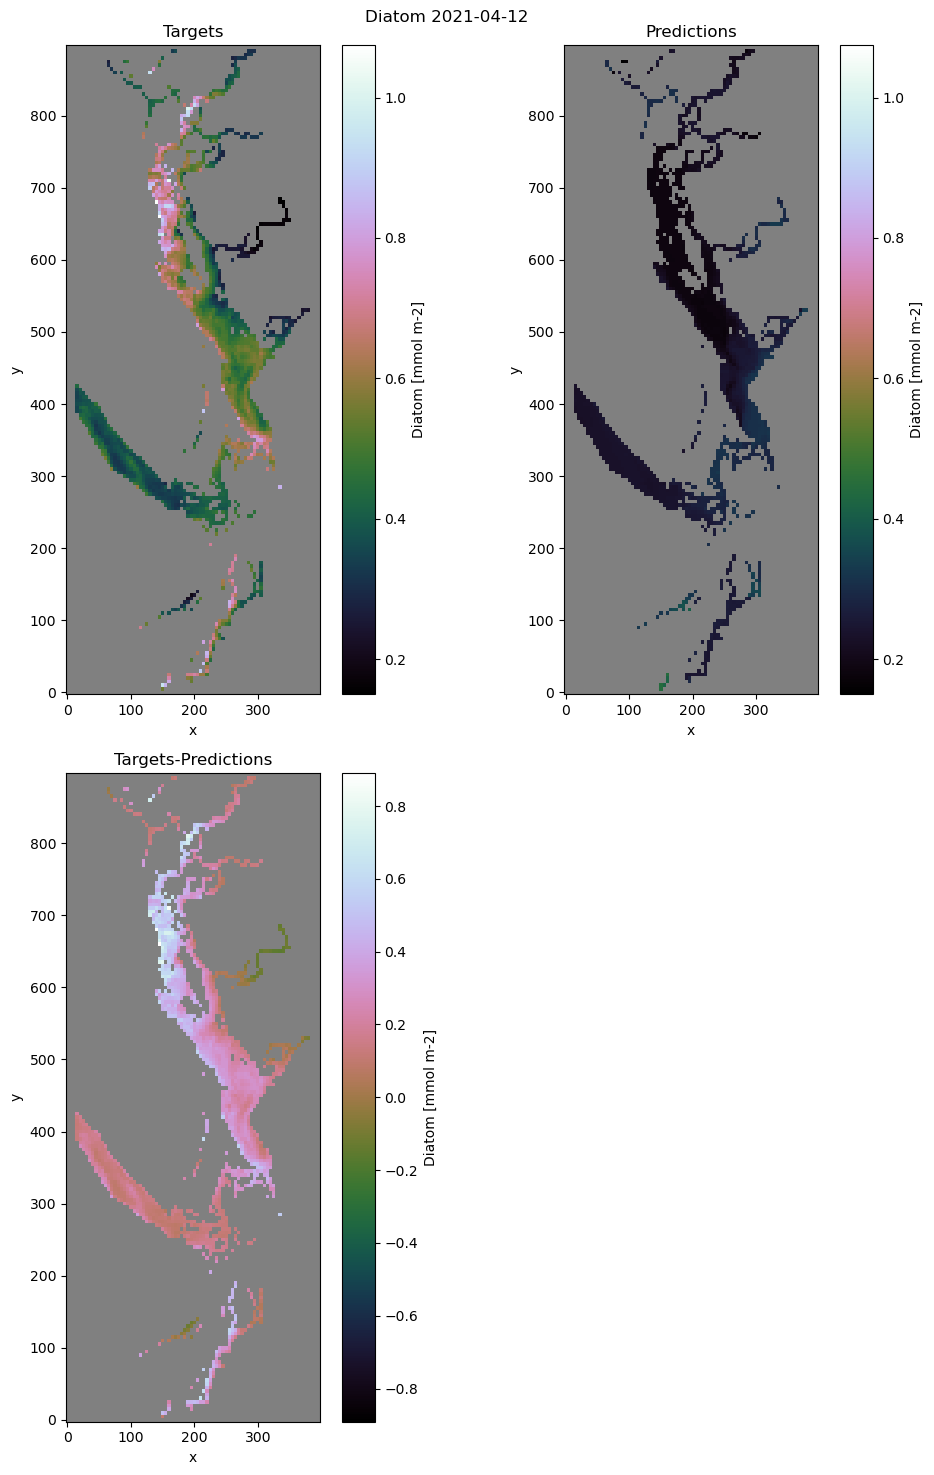

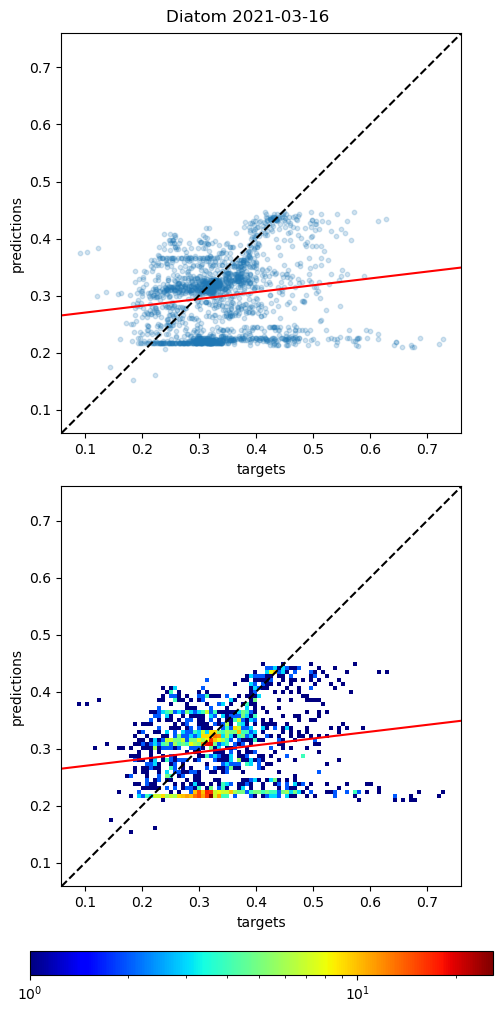

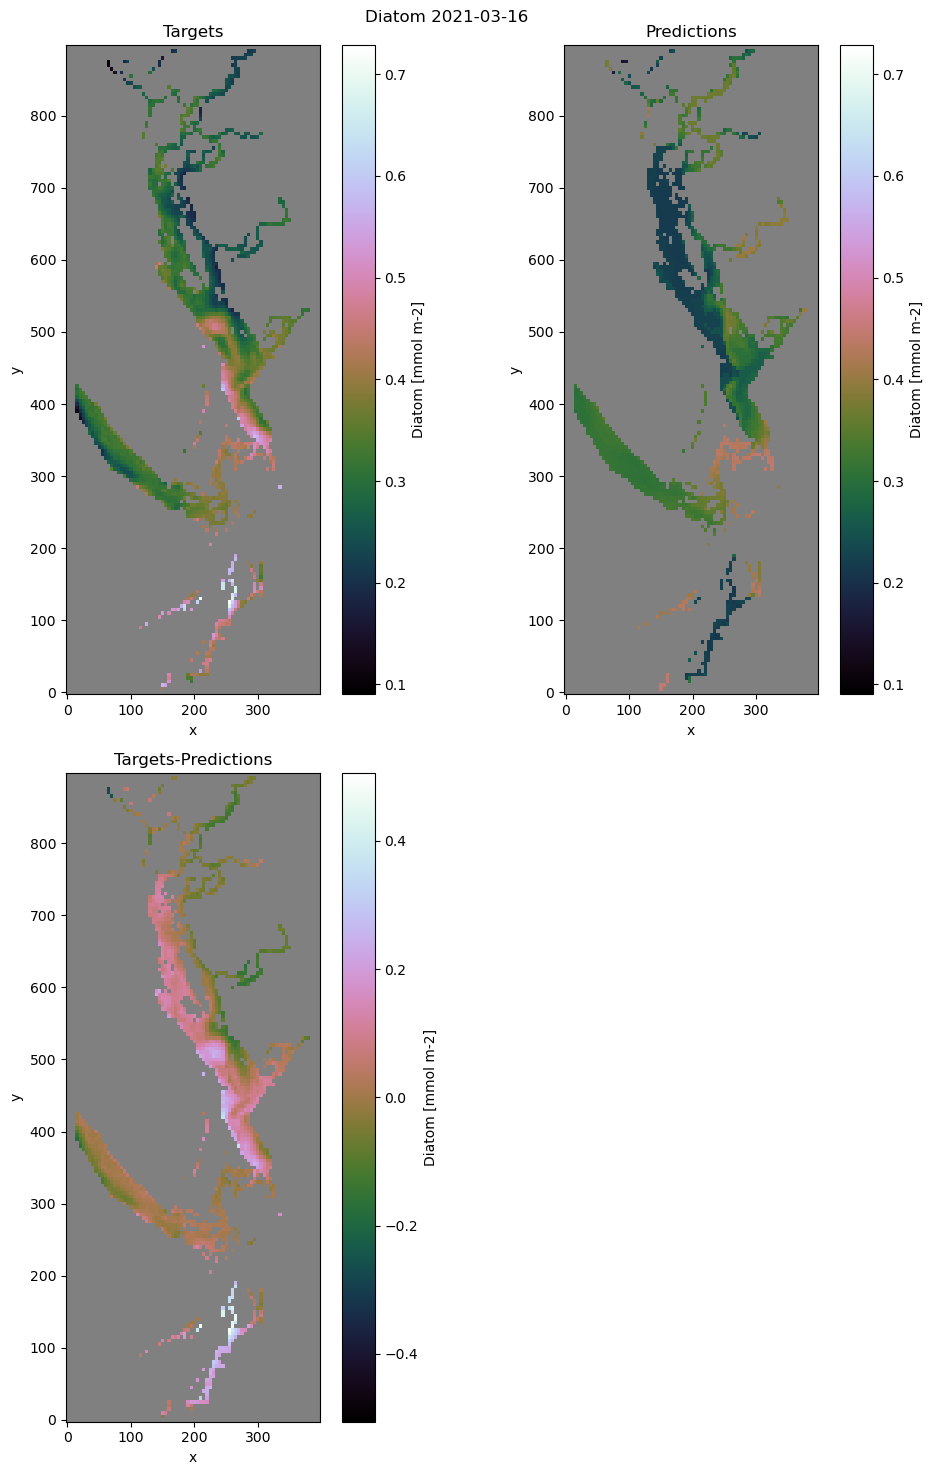

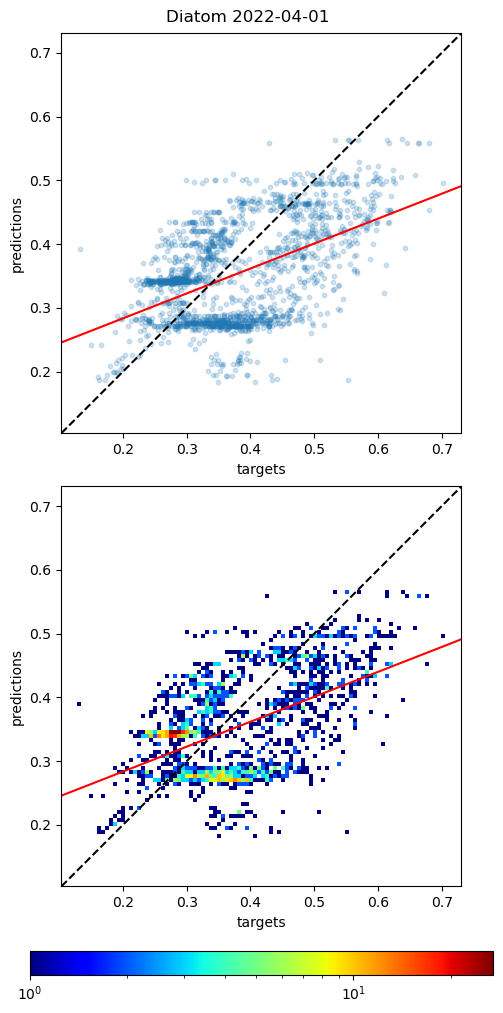

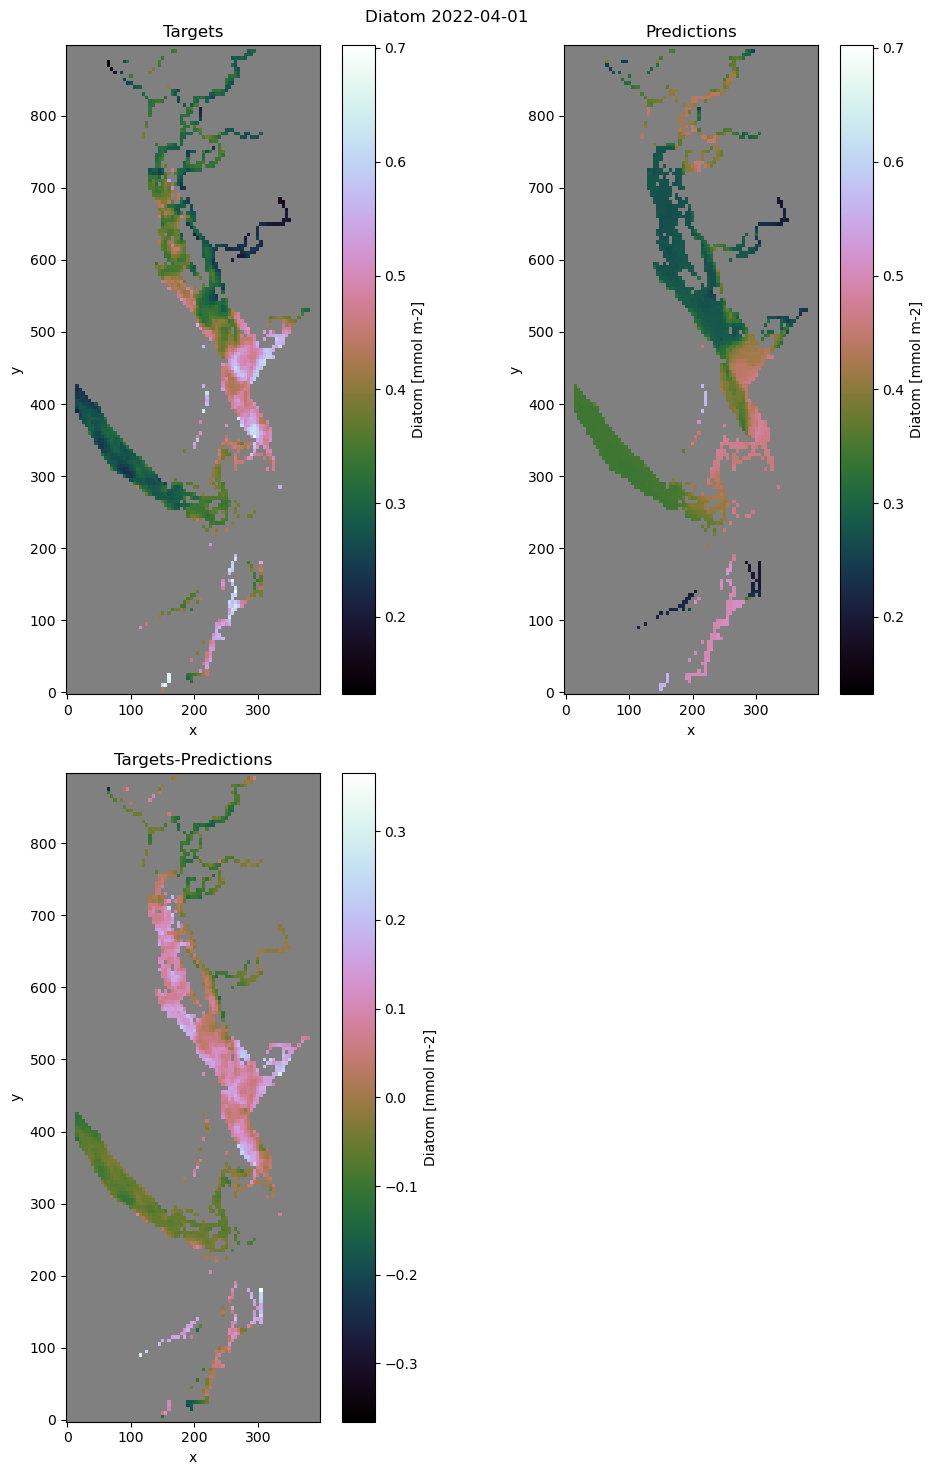

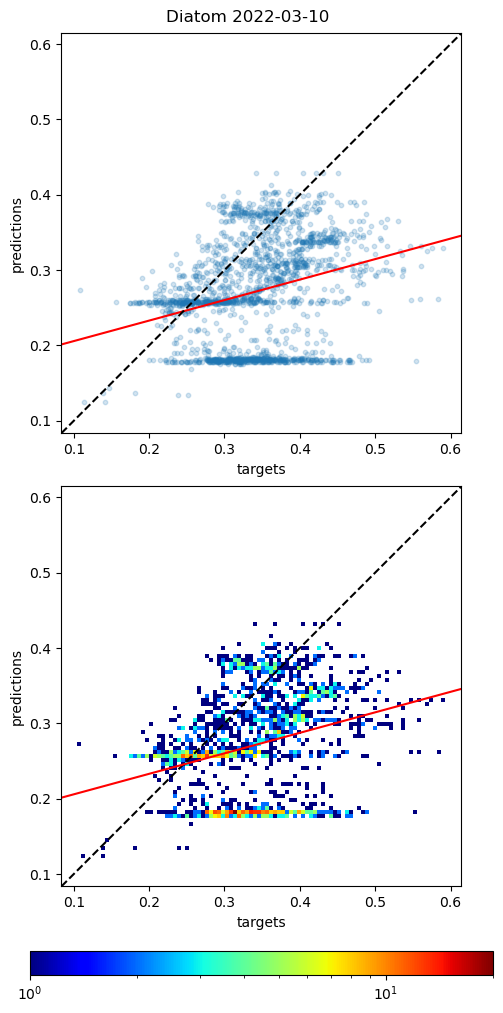

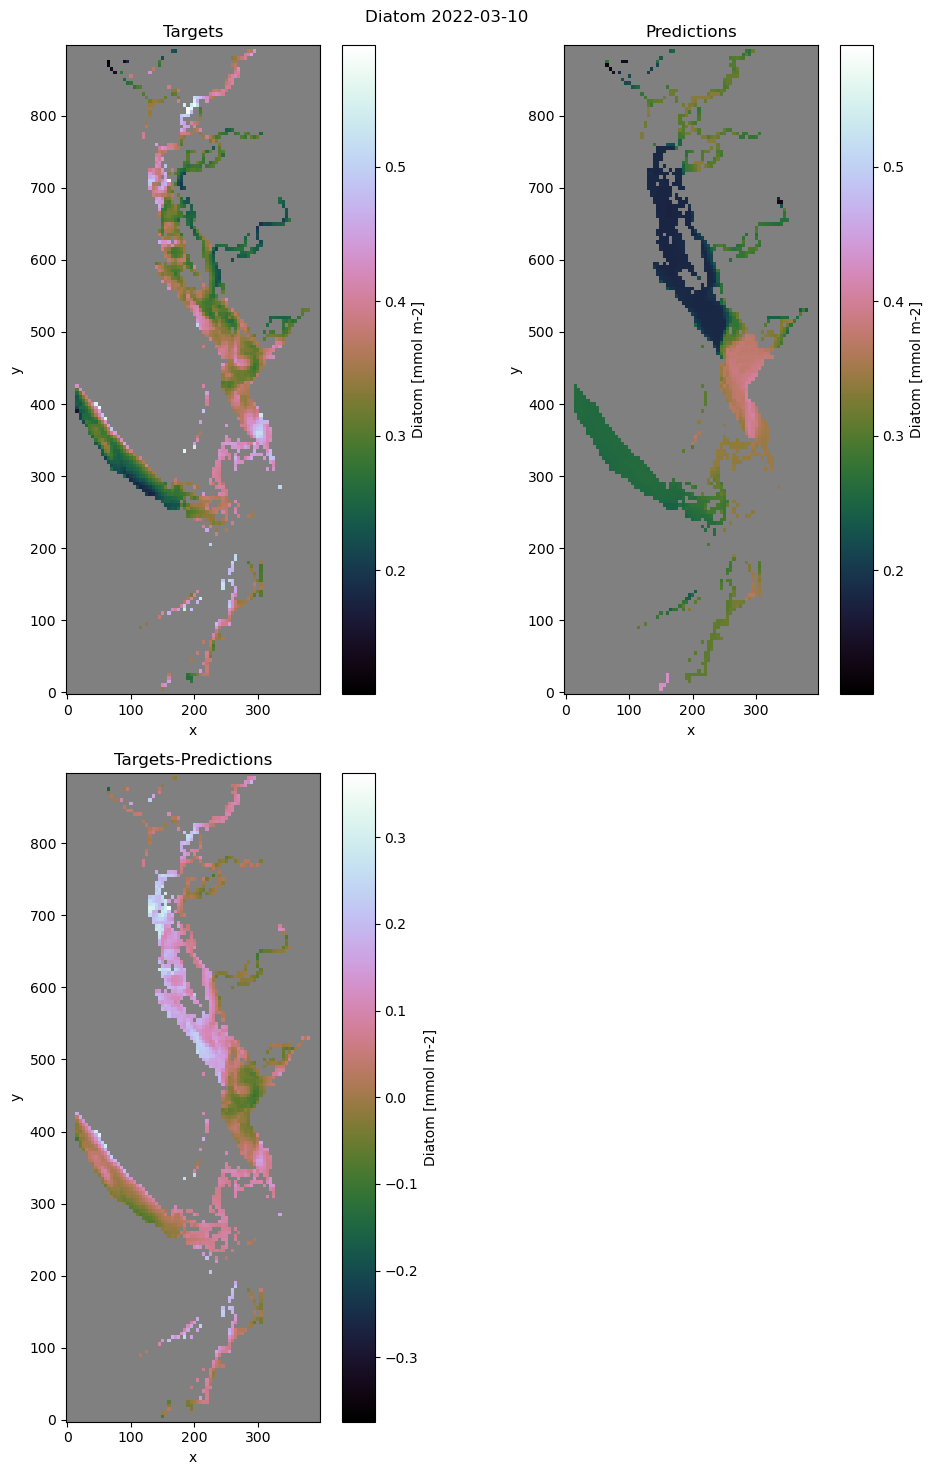

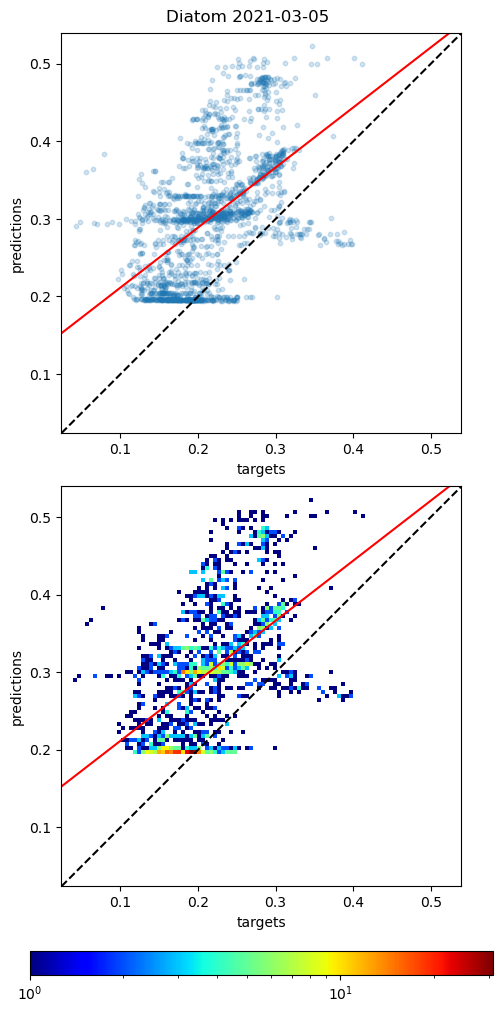

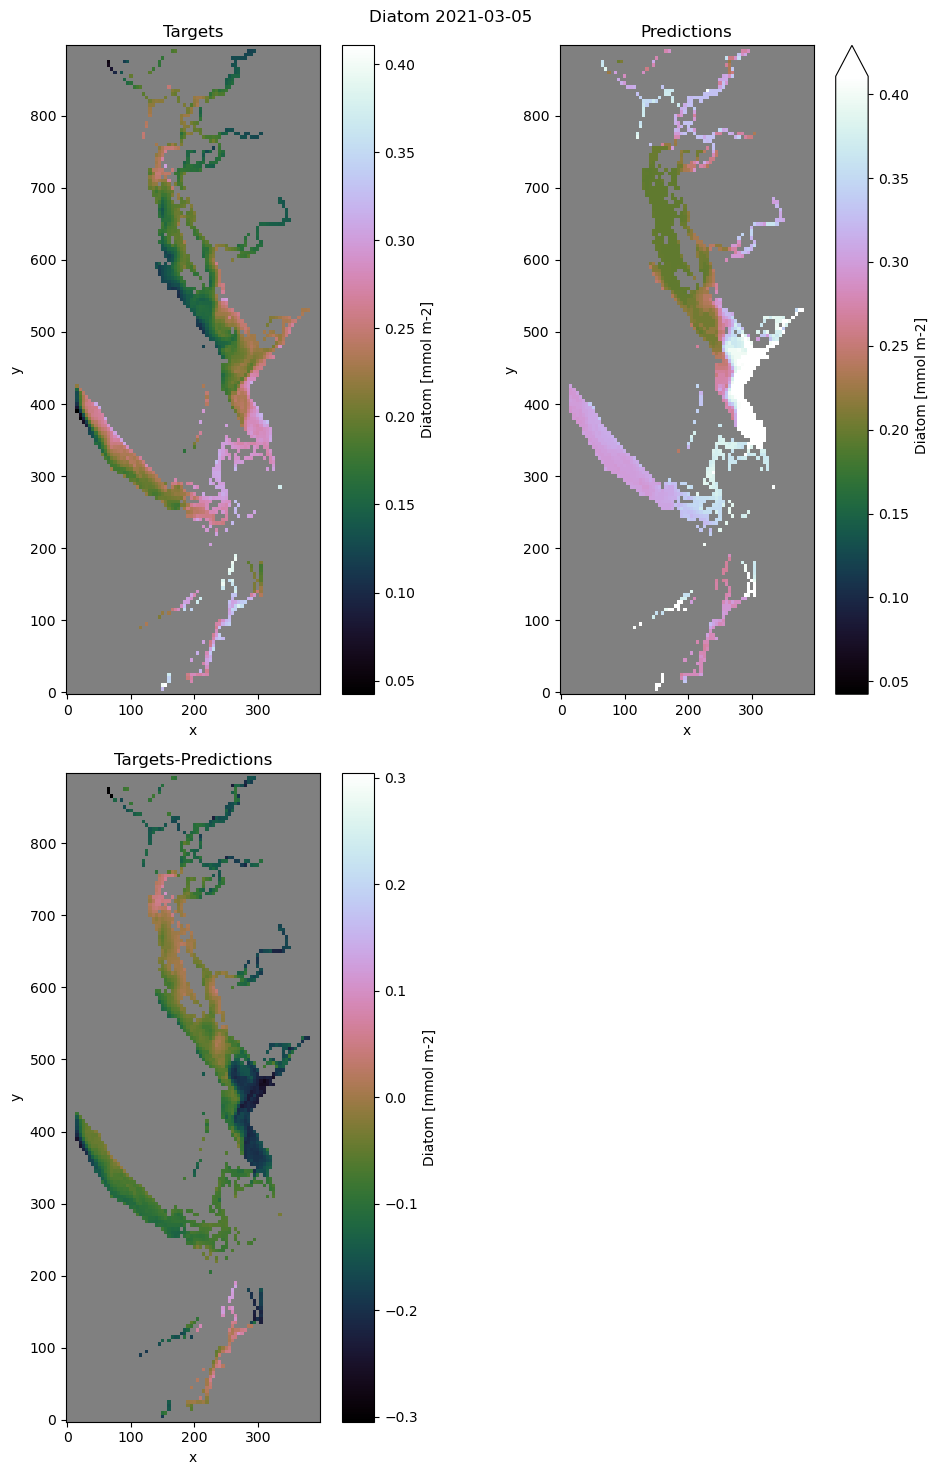

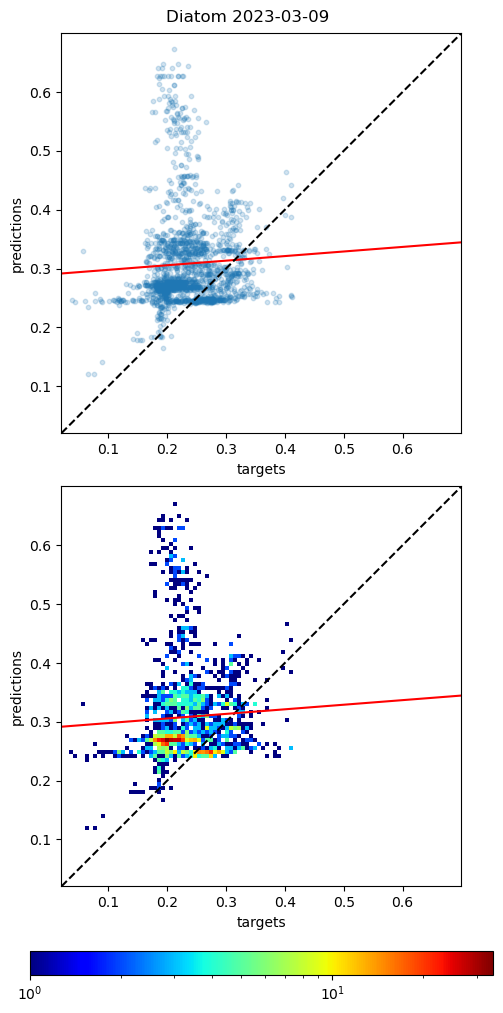

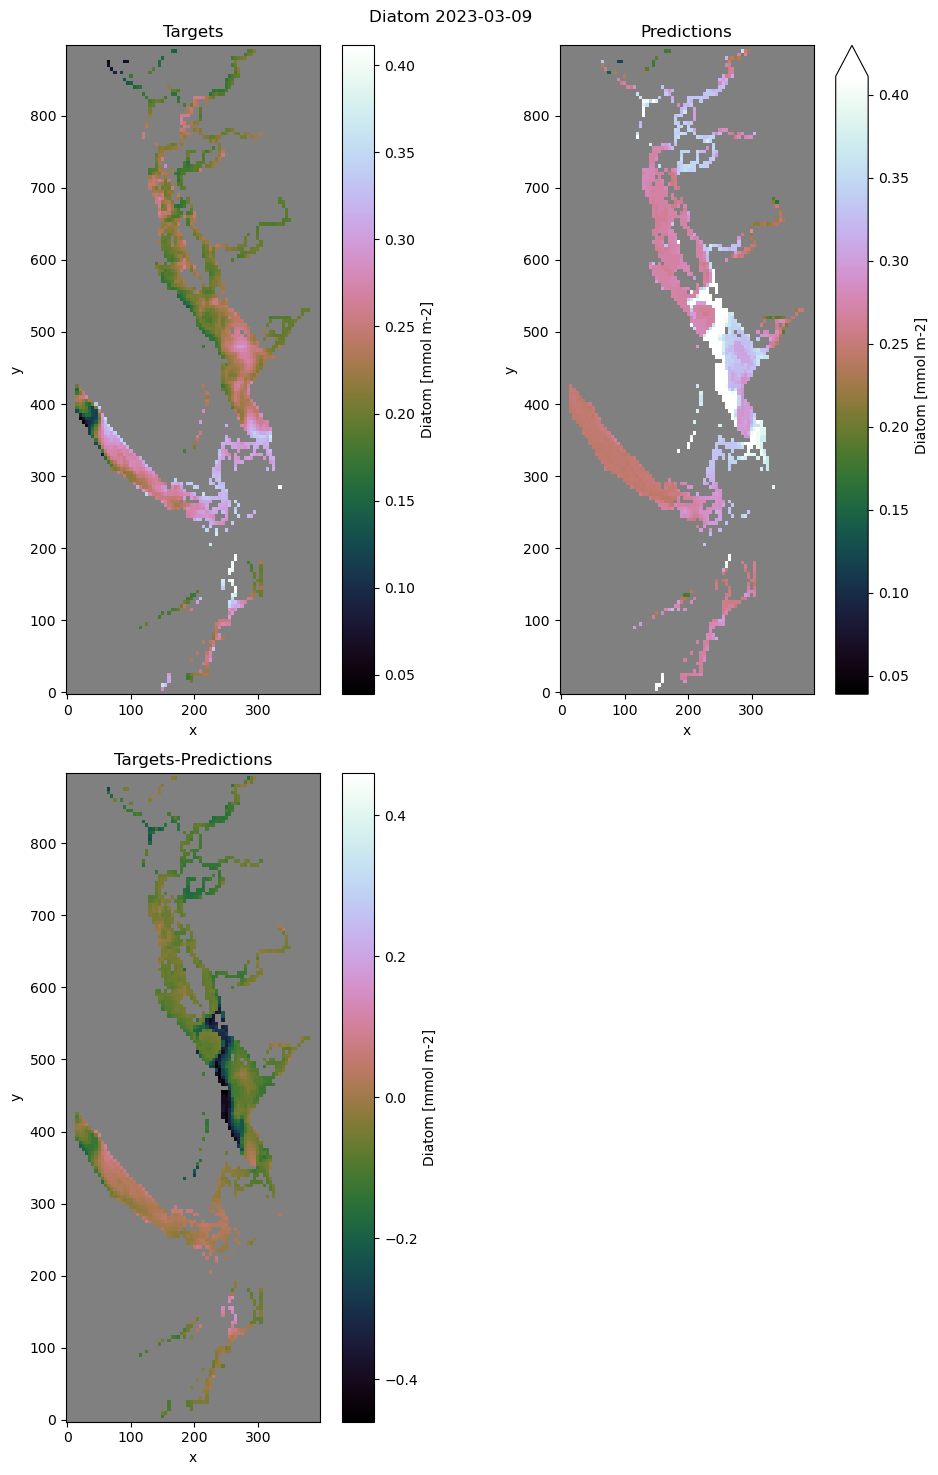

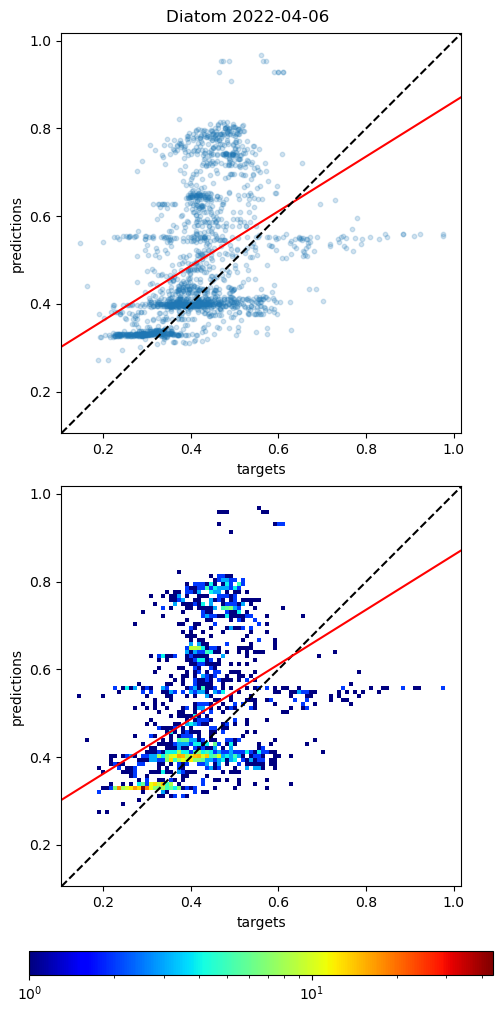

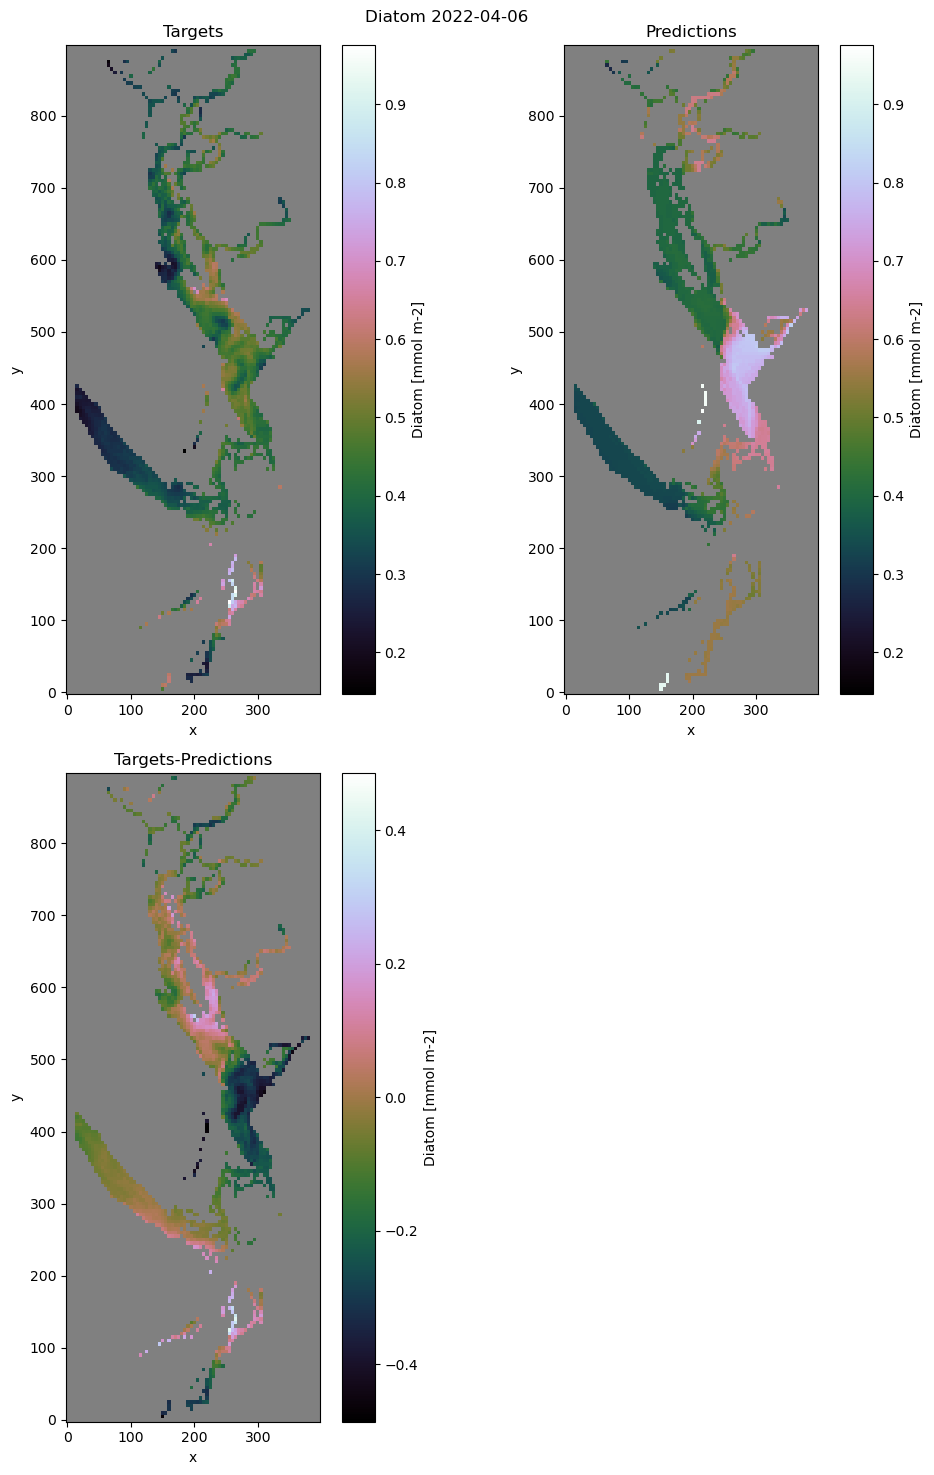

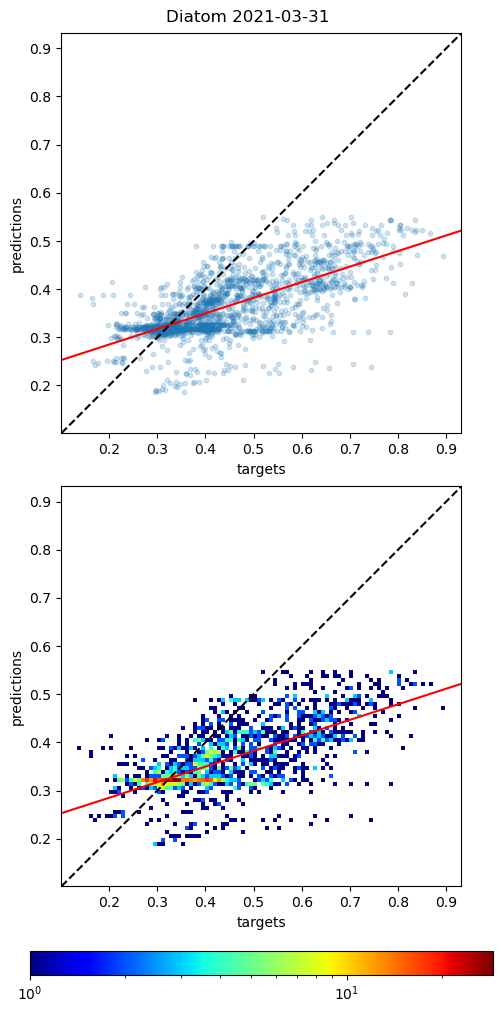

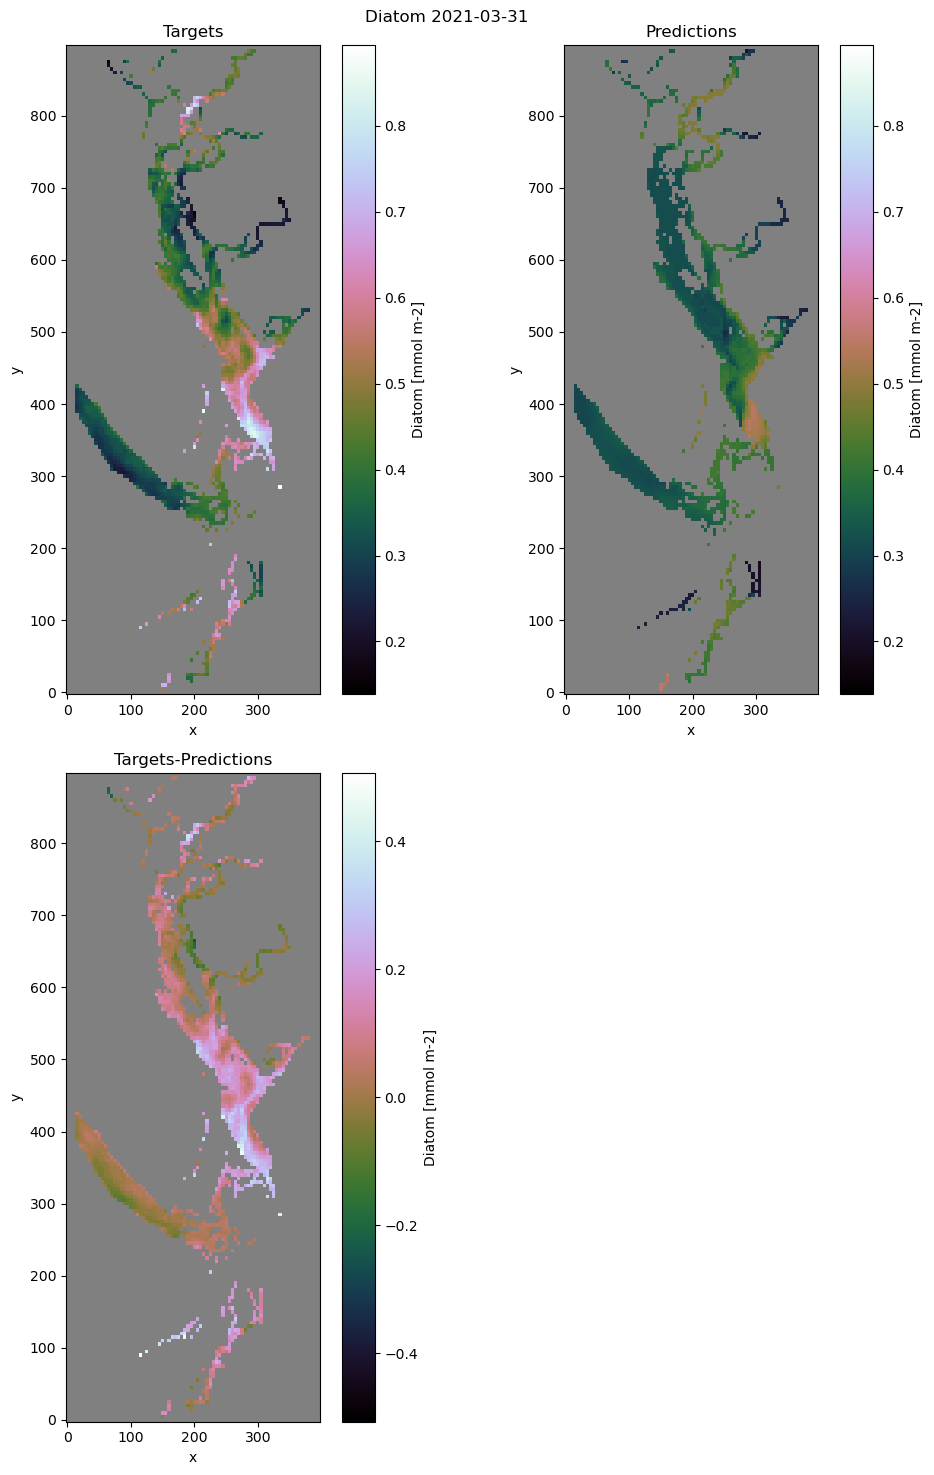

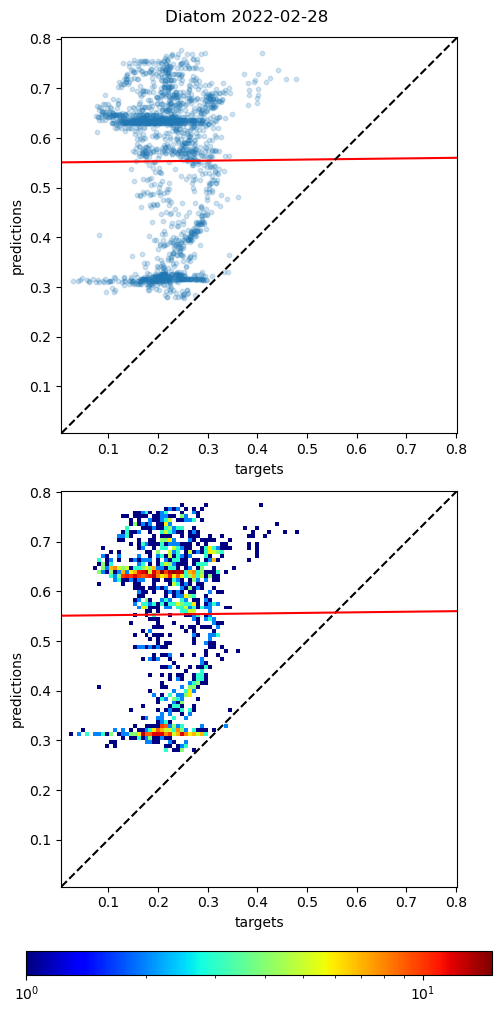

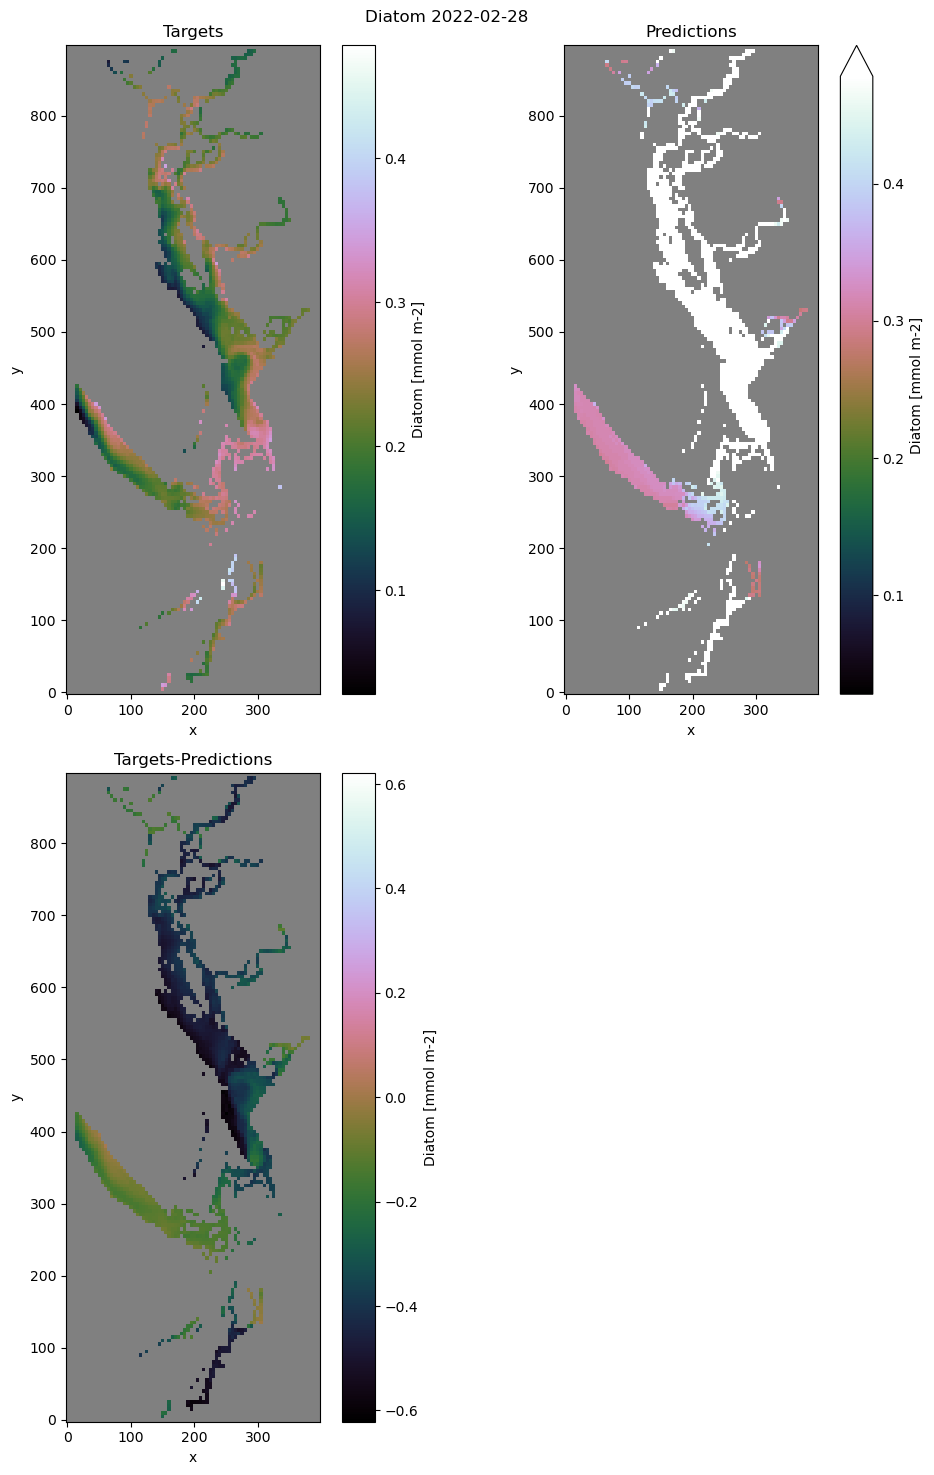

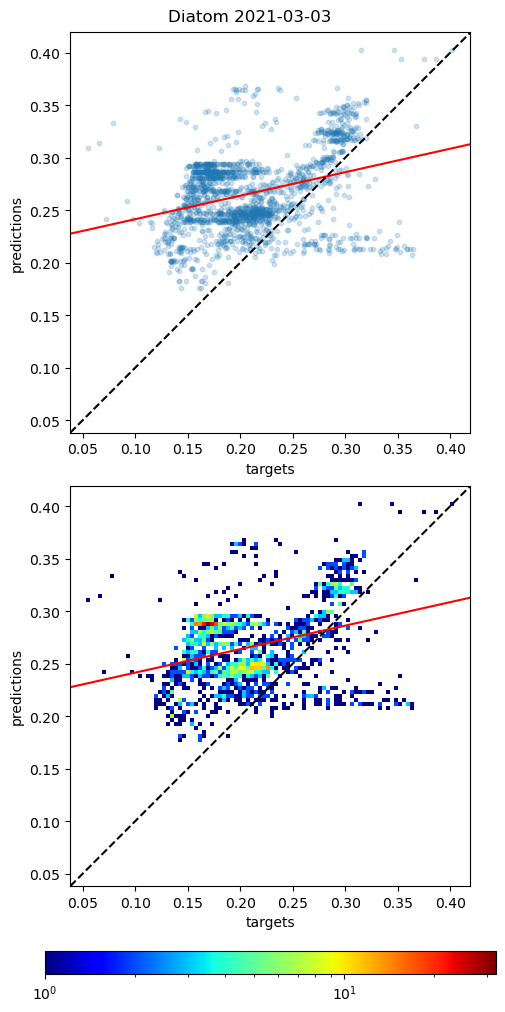

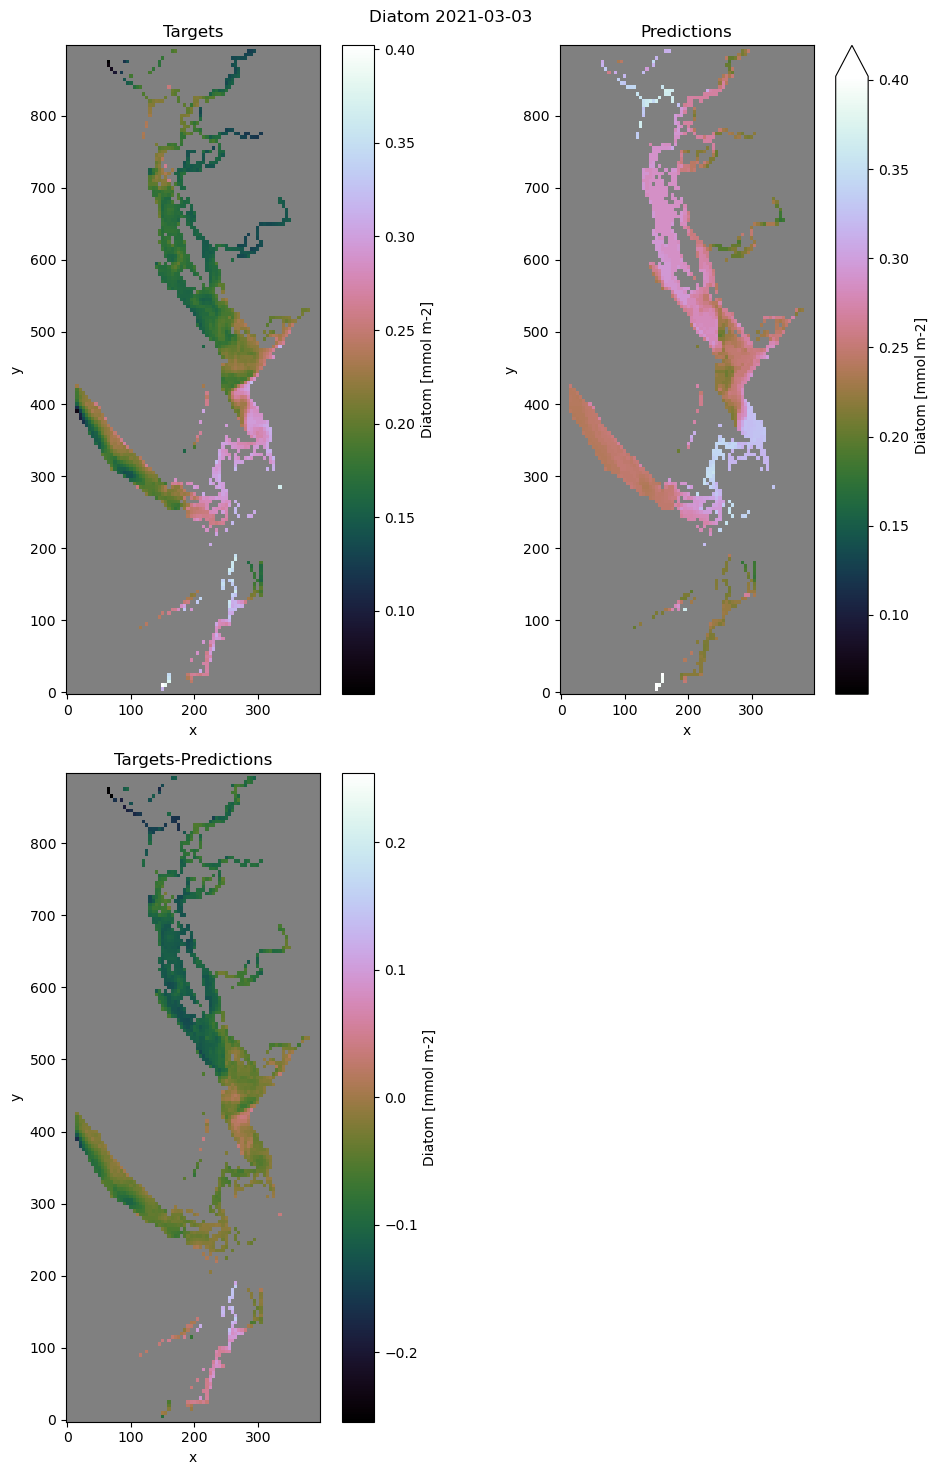

In [ ]:
plotting_criteria(dates, r_days, r_years, 'Correlation Coefficients')
plotting_criteria(dates, rms_days, rms_years, 'Root Mean Square Errors')
plotting_criteria(dates, slope_days, slope_years, 'Slopes of the best fitting line')

plotting_mean_values(dates, mean_targets, mean_predictions, units)

# Daily maps
maps = random.sample(sorted(np.arange(0,len(targets_all.time_counter))),10)
for i in maps:

    idx = np.isfinite(np.ravel(targets_all[i]))
    scatter_plot(np.ravel(targets_all[i])[idx], np.ravel(predictions_all[i])[idx], name + ' '+ str(targets_all[i].time_counter.dt.date.values))

    plotting_maps(targets_all[i], predictions_all[i], name, units)
    

## Saving

In [ ]:
path = '/data/ibougoudis/MOAD/files/results/' + name + '/func_reg/'
os.makedirs(path, exist_ok=True)
with lzma.open(path + 'regr.xz', 'wb') as f:
    dill.dump(regr, f)

file_creation(path, targets_all, 'Targets')
file_creation(path, predictions_all, 'Predictions')
file_creation(path, (targets_all-predictions_all), 'Targets - Predictions')
